Using device: cuda
Initial data shape: (100000, 10)

Initial data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Strike        100000 non-null  int64  
 1   Barrier       100000 non-null  int64  
 2   Maturity      100000 non-null  float64
 3   Spot          100000 non-null  int64  
 4   Rate          100000 non-null  float64
 5   Volatility    100000 non-null  float64
 6   BarrierType   100000 non-null  int64  
 7   ExerciseType  100000 non-null  int64  
 8   OptionType    100000 non-null  int64  
 9   Price         100000 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 7.6 MB
None

Initial data description:
              Strike        Barrier       Maturity           Spot  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean     4697.085270    4684.127120       4.996399    4698.946940   
s

/home/bren/anaconda3/envs/rapids-24.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/500], Train Loss: 6585393.6250, Val Loss: 6655442.5000
Epoch [20/500], Train Loss: 6395929.4875, Val Loss: 6538286.5000
Epoch [30/500], Train Loss: 6074711.5500, Val Loss: 6322806.0000
Epoch [40/500], Train Loss: 5800301.9375, Val Loss: 5965312.0000
Epoch [50/500], Train Loss: 5517169.5125, Val Loss: 5734656.5000
Epoch [60/500], Train Loss: 5058632.8812, Val Loss: 5207255.0000
Epoch [70/500], Train Loss: 4154648.7188, Val Loss: 4342263.0000
Epoch [80/500], Train Loss: 3167107.7812, Val Loss: 3046775.0000
Epoch [90/500], Train Loss: 2304142.5625, Val Loss: 2337151.7500
Epoch [100/500], Train Loss: 1825540.1781, Val Loss: 1447804.5000
Epoch [110/500], Train Loss: 1533661.5250, Val Loss: 1092709.3750
Epoch [120/500], Train Loss: 1279216.0141, Val Loss: 747881.2500
Epoch [130/500], Train Loss: 1267788.1281, Val Loss: 834458.0000
Epoch [140/500], Train Loss: 959326.6281, Val Loss: 470804.3125
Epoch [150/500], Train Loss: 943988.9766, Val Loss: 453111.7500
Epoch [160/500], Train Lo

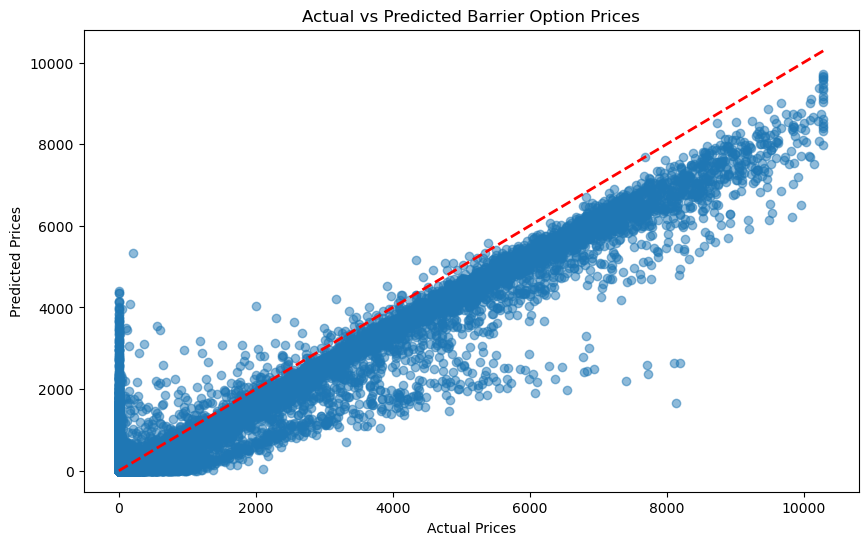

Mean Absolute Error: 345.9162
Root Mean Squared Error: 649.7469
R-squared Score: 0.9217


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EnhancedBarrierOptionModel(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedBarrierOptionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(self.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.leaky_relu(self.bn3(self.fc3(x))))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

def clean_and_diagnose_data(df):
    print("Initial data shape:", df.shape)
    print("\nInitial data info:")
    print(df.info())
    print("\nInitial data description:")
    print(df.describe())
    
    # Function to identify and handle extreme values
    def handle_extreme_values(series, lower_quantile=0.001, upper_quantile=0.999):
        lower_bound = series.quantile(lower_quantile)
        upper_bound = series.quantile(upper_quantile)
        return series.clip(lower_bound, upper_bound)
    
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Handle extreme values for each numeric column
    for col in numeric_cols:
        print(f"\nHandling extreme values for column: {col}")
        print("Before:")
        print(df[col].describe())
        df[col] = handle_extreme_values(df[col])
        print("After:")
        print(df[col].describe())
    
    print("\nChecking for infinite values after handling extremes:")
    print(df.isin([np.inf, -np.inf]).sum())
    
    print("\nChecking for NaN values:")
    print(df.isna().sum())
    
    # Fill any remaining NaN with median for numeric columns and mode for categorical
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    print("\nFinal data shape after cleaning:", df.shape)
    print("\nFinal data description:")
    print(df.describe())
    
    return df

def train_model():
    # Load data
    file_path = 'barriers_v2_100K.zip'
    data = pd.read_csv(file_path, compression='zip')
    
    # Clean and diagnose data
    data = clean_and_diagnose_data(data)
    
    # Feature engineering
    data['TimeToMaturity'] = data['Maturity']
    data['Moneyness'] = data['Spot'] / data['Strike']
    
    # Separate features and target
    X = data.drop('Price', axis=1)
    y = data['Price']
    
    # Identify numeric and categorical columns
    numeric_features = ['Strike', 'Barrier', 'Maturity', 'Spot', 'Rate', 'Volatility', 'TimeToMaturity', 'Moneyness']
    categorical_features = ['BarrierType', 'ExerciseType', 'OptionType']

    # Create preprocessing steps
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler(quantile_range=(0.001, 0.999)))
    ])
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit the preprocessor and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    # Scale the target variable
    y_scaler = RobustScaler(quantile_range=(0.001, 0.999))
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y_scaled, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
    
    # Initialize the model
    input_dim = X_train.shape[1]
    model = EnhancedBarrierOptionModel(input_dim=input_dim).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1, verbose=True)
    
    # Training loop
    num_epochs = 500
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test_tensor)
            val_loss = criterion(val_predictions, y_test_tensor).item()
            val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        print(f'Final Test Loss: {test_loss.item():.4f}')
    
    # Inverse transform predictions and true values
    test_predictions_original = y_scaler.inverse_transform(test_predictions.cpu().numpy())
    y_test_original = y_scaler.inverse_transform(y_test)
    
    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, test_predictions_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Barrier Option Prices')
    plt.show()
    
    # Calculate and print error metrics
    mae = mean_absolute_error(y_test_original, test_predictions_original)
    mse = mean_squared_error(y_test_original, test_predictions_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, test_predictions_original)
    
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'R-squared Score: {r2:.4f}')

if __name__ == "__main__":
    train_model()